In [1]:
# Parameters
baristas = 3 
simulation_hours = 9
obtain_reproducible_results = True

morning_rush = 1.25 # hours (how long the morning rush lasts)
prushed = 80 # % of customers that are rushed in the morning 

prushed_a = 30 # % of customers that are rushed at other times of the day

# Adjust Barista Thresholds
# Add:     Current Queue > 8 & Current Baristas < 5
# Remove:  Current Queue < 3 & Current Baristas > 2
mod_baristas_q_threshold = [3, 8]
mod_baristas_b_threshold = [2, 5]

minimum_service_time = 5
mean_service_time =  12
maximum_service_time = 15 
mean_inter_arrival_time = 2

# Counts
joi = 0
bal = 0
ren = 0

# Parameter Calculation Prep
morning_rush_sec = morning_rush * 3600
fixed_simulation_time =  simulation_hours*60*60 

parameter_string_list = [str(simulation_hours),'hours',
              str(baristas),str(minimum_service_time),
              str(mean_service_time),str(maximum_service_time),
              str(mean_inter_arrival_time),str(prushed)]
separator = '-'        
simulation_file_identifier = separator.join(parameter_string_list)

import numpy as np 
import pandas as pd 
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
import queue 
from functools import partial, wraps
import simpy 
import random

if obtain_reproducible_results: 
    np.random.seed(9999)

caseinfo = pd.DataFrame(columns = ["caseid", "casetype", "qmax", "wmax"])

def addcase (env, caseinfo_log, caseinfo, caseid):
    global prushed, morning_rush_sec, prushed_a
    time = env.now
    if time > morning_rush_sec:
        prushed = prushed_a
    if np.random.binomial(1, prushed/100, size = 1)[0] == 1:
        casetype = "rushed"
        qmax = 10
        wmax = 5 * mean_service_time
    else:
        casetype = "relaxed" 
        qmax = 20
        wmax = 10 * mean_service_time               
    newcase = pd.DataFrame([[caseid, casetype, qmax, wmax]], 
                           columns = ["caseid", "casetype", "qmax", "wmax"]) 
    env.process(caseinfo_log_append(env, caseid, casetype, qmax, wmax, caseinfo_log)) 
    return pd.concat([caseinfo, newcase])

def random_service_time(minimum_service_time,mean_service_time,maximum_service_time) :
    try_service_time = np.random.exponential(scale = mean_service_time)
    if (try_service_time < minimum_service_time):
        return(minimum_service_time)
    if (try_service_time > maximum_service_time):
        return(maximum_service_time)
    if (try_service_time >= minimum_service_time) and (try_service_time <= maximum_service_time):
        return(try_service_time)


def arrival(env, caseid, caseid_queue, caseinfo, caseinfo_log, event_log):
    caseid = 0

    prev_cust = caseinfo_log[caseid-1]
    previous_casetype = caseinfo_log[caseid-1][1]
    global joi, bal, ren
    while True:  
        inter_arrival_time = round(60*np.random.exponential(scale = mean_inter_arrival_time))
        print()
        print(f"⏯️Next Customer Arrives @ {env.now + inter_arrival_time}")

        yield env.timeout(inter_arrival_time)
        caseid += 1
        caseinfo = addcase(env, caseinfo_log, caseinfo, caseid) 
#        print("\nCASE ADDED TO CASEINFO:")
        print()
        print(caseinfo.loc[caseinfo["caseid"] == caseid])
        if len(caseinfo.index) == 1:
            print(f"🛬Customer Arrives | Case:{caseid} | Time:{env.now}                           {len(caseinfo.index)} customer has been logged.")
        else:
            print(f"🛬Customer Arrives | Case:{caseid} | Time:{env.now}                           {len(caseinfo.index)} customers have been logged.")
            
        balking_queue_length = caseinfo.loc[caseinfo["caseid"] == caseid]["qmax"].values[0]
        
        time = env.now
        activity = 'arrival'
        env.process(event_log_append(env, caseid, time, activity, event_log)) 
        yield env.timeout(0) 
        
        latest_rushed = -1
        
        highest_length_cust = None
        ran = 0

        if caseid_queue.qsize() > 2: 
            reduced_qmax = prev_cust[2] // 2 
        else:
            reduced_qmax = prev_cust[2]
        
        for position in range(caseid_queue.qsize()):
            if previous_casetype == 'rushed' and position != 0 and reduced_qsize > 0:
                latest_rushed = position
                highest_length_cust = prev_cust
                reduced_qsize -= 1
                ran = random.random()
        
        if highest_length_cust and caseid_queue.qsize() > reduced_qmax and ran > 0.5:   
            print(f"😡Customer #{caseid-1} Reneges | Time:{env.now} | {caseid_queue.qsize()} in line") 
            ren += 1
            env.process(event_log_append(env, caseid-1, env.now, 'renege', event_log)) 
            ren_flag = True
        else:
            ren_flag = False


        if caseid_queue.qsize() < balking_queue_length:
            caseid_queue.put(caseid)          
            print(f"↔️Customer #{caseid} Joins Queue | Time:{env.now} | {caseid_queue.qsize()} in line")
            time = env.now
            activity = 'join_queue'
            joi +=1
            env.process(event_log_append(env, caseid, time, activity, event_log)) 
            env.process(service_process(env, caseid_queue, caseinfo, event_log, ren_flag))   
        else:
            bal += 1
            print(f"😠Customer #{caseid} Balks | Time:{env.now} | {caseid_queue.qsize()} in line") 
            env.process(event_log_append(env, caseid, env.now, 'balk', event_log)) 



"""

"""

class DynamicResource:
    """
    A wrapper for simpy.Resource to allow dynamic capacity adjustment.
    """
    def __init__(self, env, initial_capacity):
        self.env = env
        self.capacity = initial_capacity
        self.resource = simpy.Resource(env, capacity=initial_capacity)
        self.joi = joi

    def request(self):
        return self.resource.request()

    def release(self, req):
        return self.resource.release(req)

    def adjust_capacity(self, new_capacity):
        """
        Replace the current resource with a new one with the updated capacity.
        """
        if new_capacity != self.capacity:
            print(f"Time {self.env.now}: Adjusting baristas from {self.capacity} to {new_capacity}.")
            self.capacity = new_capacity
            self.resource = simpy.Resource(self.env, capacity=new_capacity)


def adjust_baristas(env, caseid_queue, dynamic_resource, barista_allocation_interval=10):
    while True:
        yield env.timeout(barista_allocation_interval) 
        current_queue_length = caseid_queue.qsize()
        new_capacity = dynamic_resource.capacity

        if current_queue_length > mod_baristas_q_threshold[1] and dynamic_resource.capacity < mod_baristas_b_threshold[1]:  # Increase baristas
            new_capacity += 1
            print(f"                                               ➕Baristas")
        elif current_queue_length < mod_baristas_q_threshold[0] and dynamic_resource.capacity > mod_baristas_b_threshold[0]:  # Decrease baristas
            new_capacity -= 1
            print(f"                                               ➖Baristas")
        
        dynamic_resource.adjust_capacity(new_capacity)


env = simpy.Environment()

dynamic_baristas = DynamicResource(env, baristas)

def service_process(env, caseid_queue, caseinfo, event_log, ren_flag):
    if ren_flag: 
        print(f"❌Service Stopped for {caseid_queue.queue[0]} due to reneging.")
        return 
    
    with dynamic_baristas.request() as req:
        yield req
        queue_length_on_entering_service = caseid_queue.qsize()
        caseid = caseid_queue.get()
        
        print(f"🎬 | Case:{caseid} | Time:{env.now} | {queue_length_on_entering_service} in line")
        env.process(event_log_append(env, caseid, env.now, 'begin_service', event_log))
        
        service_time = round(60 * random_service_time(minimum_service_time, mean_service_time, maximum_service_time))
        yield env.timeout(service_time)
        queue_length_on_leaving_service = caseid_queue.qsize()
        
        print(f"🔚 | Case:{caseid} | Time:{env.now} | {queue_length_on_entering_service} in line")
        env.process(event_log_append(env, caseid, env.now, 'end_service', event_log))




"""

"""


def trace(env, callback):
     def get_wrapper(env_step, callback):
         @wraps(env_step)
         def tracing_step():
             if len(env._queue):
                 t, prio, eid, event = env._queue[0]
                 callback(t, prio, eid, event)
             return env_step()
         return tracing_step

     env.step = get_wrapper(env.step, callback)

def trace_monitor(data, t, prio, eid, event):
     data.append((t, eid, type(event)))

def test_process(env):
     yield env.timeout(1)

def event_log_append(env, caseid, time, activity, event_log):
    event_log.append((caseid, time, activity))
    yield env.timeout(0)
         
def caseinfo_log_append(env, caseid, casetype, qmax, wmax, caseinfo_log):
    caseinfo_log.append((caseid, casetype, qmax, wmax))
    yield env.timeout(0)
         
data = []
this_trace_monitor = partial(trace_monitor, data)


trace(env, this_trace_monitor)

env.process(test_process(env))
caseid_queue = queue.Queue()

#available_baristas = simpy.Resource(env, capacity = baristas)
caseid = -1  

event_log = [(caseid,0,'null_start_simulation')]
caseinfo_log = [(caseid, "nulltype", 0, 0)]

env.process(event_log_append(env, caseid, env.now, 'start_simulation', event_log))
env.process(arrival(env, caseid, caseid_queue, caseinfo, caseinfo_log, event_log))  

""""""
env.process(adjust_baristas(env, caseid_queue, dynamic_baristas))
""""""

env.run(until = fixed_simulation_time)  


print(f"Joins: {joi} ({round((100*joi/(joi+ren+bal)), 2)}%) | Reneges: {ren} ({round((100*ren/(joi+ren+bal)), 2)}%) | Balks: {bal} ({round((100*bal/(joi+ren+bal)), 2)}%) ")



⏯️Next Customer Arrives @ 208
                                               ➖Baristas
Time 10: Adjusting baristas from 3 to 2.

  caseid casetype qmax wmax
0      1   rushed   10   60
🛬Customer Arrives | Case:1 | Time:208                           1 customer has been logged.
↔️Customer #1 Joins Queue | Time:208 | 1 in line

⏯️Next Customer Arrives @ 212
🎬 | Case:1 | Time:208 | 1 in line

  caseid casetype qmax wmax
0      2   rushed   10   60
🛬Customer Arrives | Case:2 | Time:212                           2 customers have been logged.
↔️Customer #2 Joins Queue | Time:212 | 1 in line

⏯️Next Customer Arrives @ 237
🎬 | Case:2 | Time:212 | 1 in line

  caseid casetype qmax wmax
0      3   rushed   10   60
🛬Customer Arrives | Case:3 | Time:237                           3 customers have been logged.
↔️Customer #3 Joins Queue | Time:237 | 1 in line

⏯️Next Customer Arrives @ 318

  caseid casetype qmax wmax
0      4   rushed   10   60
🛬Customer Arrives | Case:4 | Time:318                  

In [2]:
caseinfo_log_list = [list(element) for element in caseinfo_log]

caseid_list = []
casetype_list = []
qmax_list = []
wmax_list = []
for d in caseinfo_log_list:
    if d[0] > 0:
        caseid_list.append(d[0])
        casetype_list.append(d[1])
        qmax_list.append(d[2])
        wmax_list.append(d[3])
caseinfo_log_df = pd.DataFrame({'caseid':caseid_list,
                             'casetype':casetype_list,
                             'qmax': qmax_list,
                             'wmax':wmax_list})    
print()
print('caseinfo log stored as Pandas data frame: caseinfo_log_df')

case_info_file_name = 'simulation-program-case-information-' + simulation_file_identifier + '.csv'
caseinfo_log_df.to_csv(case_info_file_name, index = False)

simulation_trace_file_name = 'sim-trace-' + simulation_file_identifier + '.txt'
with open(simulation_trace_file_name, 'wt') as ftrace:
    for d in data:
        print(str(d), file = ftrace)
print()        
print('simulation program trace written to file:',simulation_trace_file_name)

event_log_list = [list(element) for element in event_log]

caseid_list = []
time_list = []
activity_list = []
for d in event_log_list:
    if d[0] > 0:
        caseid_list.append(d[0])
        time_list.append(d[1])
        activity_list.append(d[2])
event_log_df = pd.DataFrame({'caseid':caseid_list,
                             'time':time_list,
                             'activity':activity_list})    
print()
print('event log stored as Pandas data frame: event_log_df')

event_log_file_name = 'sim-log-' + simulation_file_identifier + '.csv'
event_log_df.to_csv(event_log_file_name, index = False)  
print()
print('event log written to file:',event_log_file_name)

print()
print('Simulation parameter settings:')
print(baristas, 'baristas/servers')
print('  Service time settings (in minutes)')
print('    minimum:',minimum_service_time)
print('    mean:   ',mean_service_time)
print('    maximum:',maximum_service_time)
print('mean observed service times may deviate from the parameter setting')
print('due to censoring associated with the minimum and maxium')
print()
print('Customers set to arrive every', mean_inter_arrival_time, 'minute(s) on average')
print('Customers will not join the queue/waiting line if its length is longer than customers will tolerate (balking)')
print('Percentage of customers who are "rushed" and less tolerate of long lines: ', prushed, sep = '')
print('The simulation is set to run for ', simulation_hours,' hours (',60*simulation_hours,' minutes)', sep ='')
print()
end_time = np.max(event_log_df["time"])
print('Results after ',end_time, ' seconds (', round(end_time/60, 2), ' minutes, ',round(end_time/(60*60),2),' hours):', sep = '')
caseid_list = pd.unique(event_log_df['caseid'])
print(len(caseid_list), 'unique customers arrived')
print(len(event_log_df['activity'][event_log_df['activity']=='join_queue']),'customers joined the queue for service')
print(len(event_log_df['activity'][event_log_df['activity']=='balk']),'customers balked (lost business)')
print(len(event_log_df['activity'][event_log_df['activity']=='begin_service']),'customers began service')
print(len(event_log_df['activity'][event_log_df['activity']=='end_service']),'customers ended service')
print(caseid_queue.qsize(),'customers were still in line at the end of the simulation')

case_by_case_event_file_name = 'simulation-program-case-by-case-events-' + simulation_file_identifier + '.txt'
with open(case_by_case_event_file_name, 'wt') as fcasedata:
    lastcase_arrival_time = 0  
    inter_arrival_times = []
    waiting_time = [] 
    service_time = [] 
    for thiscase in caseid_list:
        thiscase_events = event_log_df[['caseid','time','activity']][event_log_df['caseid']==thiscase]
        print(file = fcasedata)
        print('events for caseid',thiscase, file = fcasedata)
        print(thiscase_events, file = fcasedata) 
        thiscase_arrival_time = thiscase_events.loc[thiscase_events['activity']=='arrival', 'time'].values[0]
        inter_arrival_time = thiscase_arrival_time - lastcase_arrival_time
        inter_arrival_times.append(inter_arrival_time)
        print(file = fcasedata)
        print('time between arrivals (this case minus previous case):',inter_arrival_time, 'seconds', file = fcasedata)
        lastcase_arrival_time  = thiscase_arrival_time 
        if thiscase_events.loc[thiscase_events['activity']=='begin_service'].shape[0] == 1:
            thiscase_begin_service = thiscase_events.loc[thiscase_events['activity']=='begin_service', 'time'].values[0]
            thiscase_join_queue = thiscase_arrival_time = thiscase_events.loc[thiscase_events['activity']=='join_queue', 'time'].values[0]
            thiscase_waiting_time = thiscase_begin_service - thiscase_join_queue
            waiting_time.append(thiscase_waiting_time)
            print('waiting time for this case (time between joining queue and beginning service):',thiscase_waiting_time, 'seconds', file = fcasedata)
        if thiscase_events.loc[thiscase_events['activity']=='end_service'].shape[0] == 1:
            thiscase_end_service = thiscase_events.loc[thiscase_events['activity']=='end_service', 'time'].values[0]
            thiscase_service_time = thiscase_end_service - thiscase_begin_service
            service_time.append(thiscase_service_time)
            print('service time for this case (time between beginning and ending service):',thiscase_service_time, 'seconds', file = fcasedata)


print('Summary statistics for customer inter-arrival times:')
print('  Minimum: ',round(np.min(inter_arrival_times),2), ' seconds (' ,round(np.min(inter_arrival_times)/60,2), ' minutes)',sep='')  
print('  Mean:    ',round(np.average(inter_arrival_times),2), ' seconds (' ,round(np.average(inter_arrival_times)/60,2), ' minutes)',sep='')  
print('  Maximum: ',round(np.max(inter_arrival_times),2), ' seconds (' ,round(np.max(inter_arrival_times)/60,2), ' minutes)',sep='')      

print()
print('Summary statistics for customer wait times:')
print('  Minimum: ',round(np.min(waiting_time),2), ' seconds (' ,round(np.min(waiting_time)/60,2), ' minutes)',sep='')  
print('  Mean:    ',round(np.average(waiting_time),2), ' seconds (' ,round(np.average(waiting_time)/60,2), ' minutes)',sep='')  
print('  Maximum: ',round(np.max(waiting_time),2), ' seconds (' ,round(np.max(waiting_time)/60,2), ' minutes)',sep='')  

print()
print('Summary statistics for service times:')
print('  Minimum: ',round(np.min(service_time),2), ' seconds (' ,round(np.min(service_time)/60,2), ' minutes)',sep='')  
print('  Mean:    ',round(np.average(service_time),2), ' seconds (' ,round(np.average(service_time)/60,2), ' minutes)',sep='')  
print('  Maximum: ',round(np.max(service_time),2), ' seconds (' ,round(np.max(service_time)/60,2), ' minutes)',sep='')  

print()        
print('simulation case-by-case event data written to file:',case_by_case_event_file_name)
print("this log is most useful in checking the logic of the simulation")

output_string_key = []
output_string_value = []

output_string_key.append("Minimum inter-arrival_time")
output_string_value.append(str(round(np.min(inter_arrival_times),2)))
output_string_key.append("Average inter-arrival_time")
output_string_value.append(str(round(np.average(inter_arrival_times),2)))
output_string_key.append("Maximum inter-arrival_time")
output_string_value.append(str(round(np.max(inter_arrival_times),2)))

output_string_key.append("Mimimum waiting time")
output_string_value.append(str(round(np.min(waiting_time),2)))
output_string_key.append("Average waiting time")
output_string_value.append(str(round(np.average(waiting_time),2)))
output_string_key.append("Maximum waiting time")
output_string_value.append(str(round(np.max(waiting_time),2)))

output_string_key.append("Mimimum service time")
output_string_value.append(str(round(np.min(service_time),2)))
output_string_key.append("Average service time")
output_string_value.append(str(round(np.average(service_time),2)))
output_string_key.append("Maximum service time")
output_string_value.append(str(round(np.max(service_time),2)))

output_table = pd.DataFrame({"key":output_string_key, "value":output_string_value})
output_table.set_index(['key'])


caseinfo log stored as Pandas data frame: caseinfo_log_df

simulation program trace written to file: sim-trace-9-hours-3-5-12-15-2-80.txt

event log stored as Pandas data frame: event_log_df

event log written to file: sim-log-9-hours-3-5-12-15-2-80.csv

Simulation parameter settings:
3 baristas/servers
  Service time settings (in minutes)
    minimum: 5
    mean:    12
    maximum: 15
mean observed service times may deviate from the parameter setting
due to censoring associated with the minimum and maxium

Customers set to arrive every 2 minute(s) on average
Customers will not join the queue/waiting line if its length is longer than customers will tolerate (balking)
Percentage of customers who are "rushed" and less tolerate of long lines: 30
The simulation is set to run for 9 hours (540 minutes)

Results after 32382 seconds (539.7 minutes, 8.99 hours):
326 unique customers arrived
302 customers joined the queue for service
24 customers balked (lost business)
293 customers began servi

,value
key,
Minimum inter-arrival_time,0
Average inter-arrival_time,99.33
Maximum inter-arrival_time,786
Mimimum waiting time,0
Average waiting time,714.89
Maximum waiting time,1832
Mimimum service time,300
Average service time,573.21
Maximum service time,900


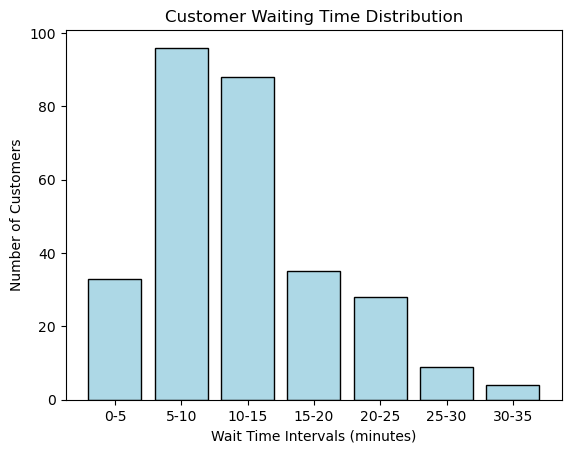

In [3]:
import matplotlib.pyplot as plt
bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100]  
bin_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30','30-35']

frequencies, _ = np.histogram(waiting_time, bins=bins)

plt.bar(bin_labels, frequencies, color='lightblue', edgecolor='black')
plt.xlabel('Wait Time Intervals (minutes)')
plt.ylabel('Number of Customers')
plt.title('Customer Waiting Time Distribution')
plt.show()

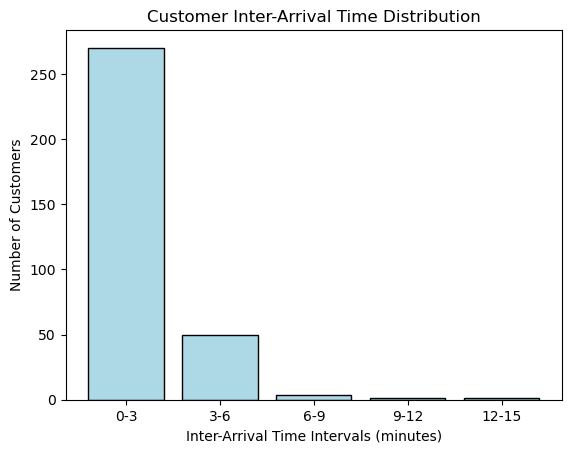

In [4]:
bins = [0, 180, 360, 540, 720, 900]
bin_labels = ['0-3', '3-6', '6-9', '9-12', '12-15']

frequencies, _ = np.histogram(inter_arrival_times, bins=bins)

plt.bar(bin_labels, frequencies, color='lightblue', edgecolor='black')
plt.xlabel('Inter-Arrival Time Intervals (minutes)')
plt.ylabel('Number of Customers')
plt.title('Customer Inter-Arrival Time Distribution')
plt.show()

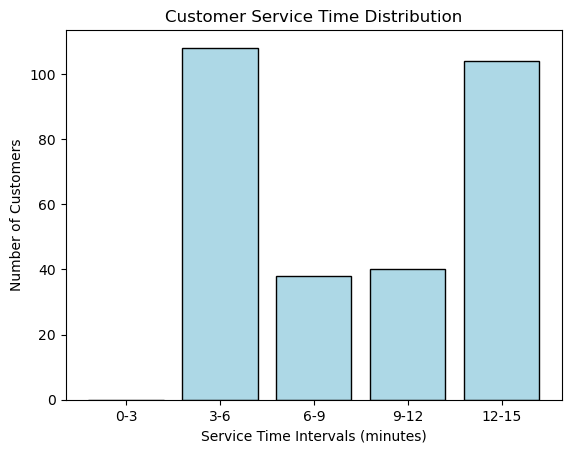

In [5]:
bins = [0, 180, 360, 540, 720, 900]
bin_labels = ['0-3', '3-6', '6-9', '9-12', '12-15']

frequencies, _ = np.histogram(service_time, bins=bins)

plt.bar(bin_labels, frequencies, color='lightblue', edgecolor='black')
plt.xlabel('Service Time Intervals (minutes)')
plt.ylabel('Number of Customers')
plt.title('Customer Service Time Distribution')
plt.show()

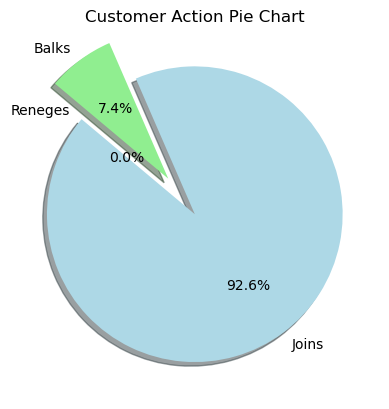

In [6]:
labels = ['Reneges', 'Joins', 'Balks']
sizes = [ren, joi, bal]
colors = ['gold', 'lightblue', 'lightgreen', 'coral']
explode = (0, 0, 0.3)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Customer Action Pie Chart')
plt.show()